In [1]:
import numpy as np
import pandas as pd

from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.structural import UnobservedComponents
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.fbprophet import Prophet

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series, plot_correlations, plot_lags

# disable all warnings because they are super annoying
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

using sktime version 0.11.4

# Demo Time Series Plots in Python

## Univariate

Model setup. We'll use the sktime `load_airline()` function to load in the data of international air passengers from 1949-1960 from the classic Box-Jenkins ARIMA paper.

In [2]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=12)
fh = ForecastingHorizon(y_test.index, is_relative=False)

You can plot simple diagnostics like the autocorrelation function (ACF) and partial ACF (PACF) with `plot_correlations()`

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Number of airline passengers'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

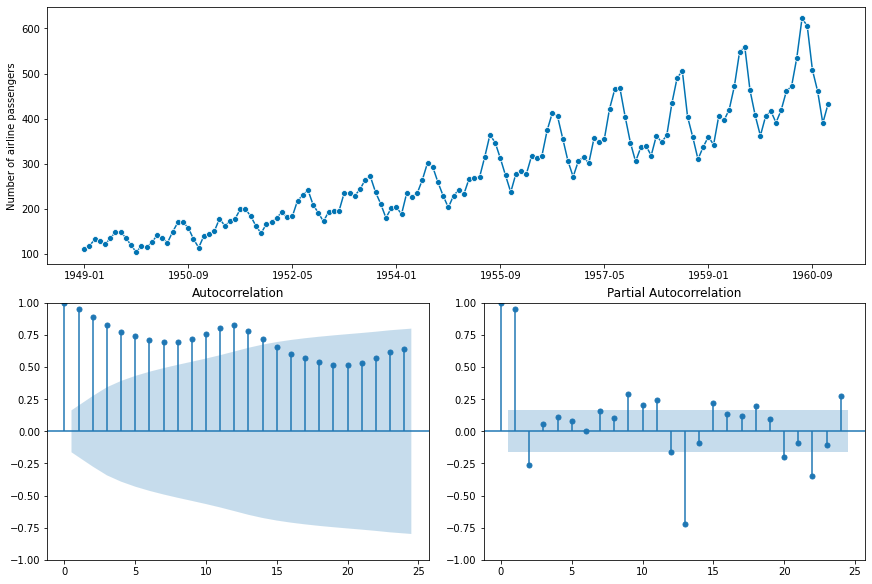

In [3]:
# ACF, PACF
plot_correlations(y)

(<Figure size 576x432 with 3 Axes>,
 array([<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>,
        <AxesSubplot:xlabel='y(t)', ylabel='y(t + 2)'>,
        <AxesSubplot:xlabel='y(t)', ylabel='y(t + 3)'>], dtype=object))

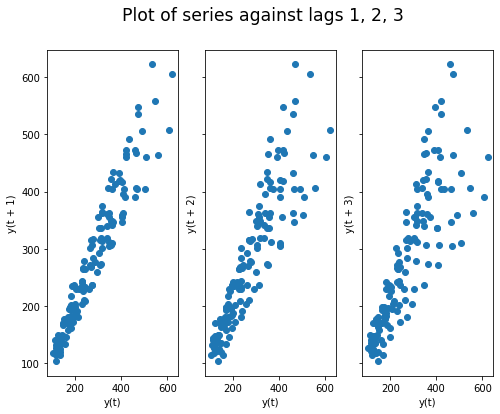

In [4]:
# scatter plot of lags vs itself
plot_lags(y, lags=[1,2,3])

## Modeling

### Theta Forecaster

sMAPE:  0.05231934588593568


(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

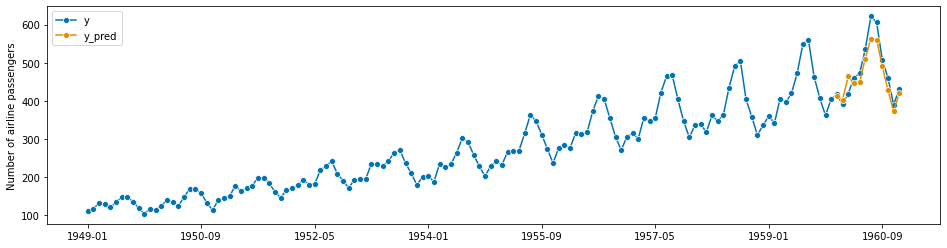

In [5]:
forecaster = ThetaForecaster(sp=12)  # monthly seasonal periodicity
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
print("sMAPE: ", mean_absolute_percentage_error(y_test, y_pred, symmetric=True))
plot_series(y, y_pred, labels=["y", "y_pred"])


Pretty Plot with Prediction Intervals

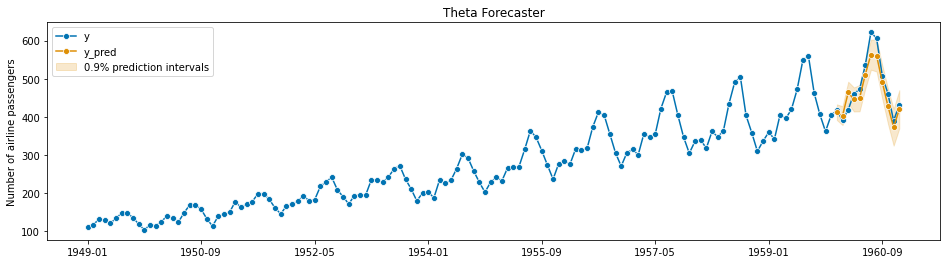

In [6]:
# Set coverage and then call .predict_interval to return a dataframe with the upper and lower PI bounds
coverage = 0.9
y_pred_ints = forecaster.predict_interval(coverage=coverage)

fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints["Coverage"][coverage]["lower"],
    y_pred_ints["Coverage"][coverage]["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{coverage}% prediction intervals",
)
ax.set_title("Theta Forecaster")
ax.legend();

Wrap up all the steps above in a function



In [7]:
def run_forecast(y_train, y_test, forecaster, fh, coverage=None, results=True, title=""):
    """Helper function to train a forecaster and plot the results"""
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"])
    if coverage is not None:
        # Calculated and add prediction intervals to the plot
        y_pred_ints = forecaster.predict_interval(coverage=coverage)
        ax.fill_between(
            ax.get_lines()[-1].get_xdata(),
            y_pred_ints["Coverage"][coverage]["lower"],
            y_pred_ints["Coverage"][coverage]["upper"],
            alpha=0.2,
            color=ax.get_lines()[-1].get_c(),
            label=f"{coverage}% prediction intervals",
        )
        ax.legend();
    ax.set_title(title)
    print("sMAPE: ", mean_absolute_percentage_error(y_test, y_pred, symmetric=True))
    if results:
        return forecaster, y_pred

Fitting a linear trendline

sMAPE:  0.12074496965455546


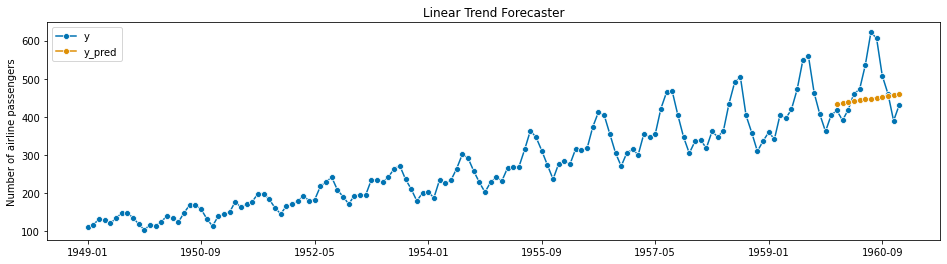

In [8]:
forecaster = PolynomialTrendForecaster(degree=1)
run_forecast(y_train, y_test, forecaster, fh, results=False, 
             title="Linear Trend Forecaster")

sMAPE:  0.11980400632932332


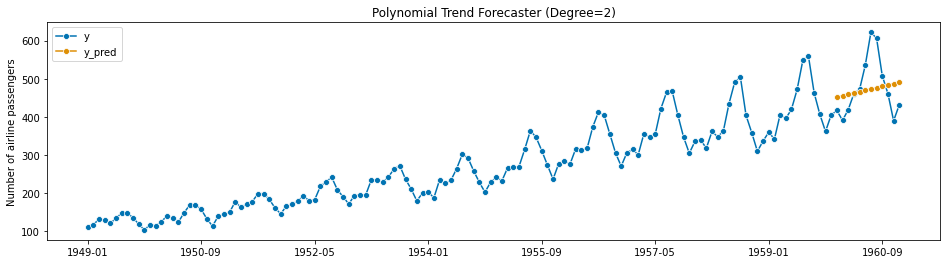

In [9]:
forecaster = PolynomialTrendForecaster(degree=2)
run_forecast(y_train, y_test, forecaster, fh, coverage=None, results=False, 
             title="Polynomial Trend Forecaster (Degree=2)")

Naive Model

sMAPE:  0.16120844670628973


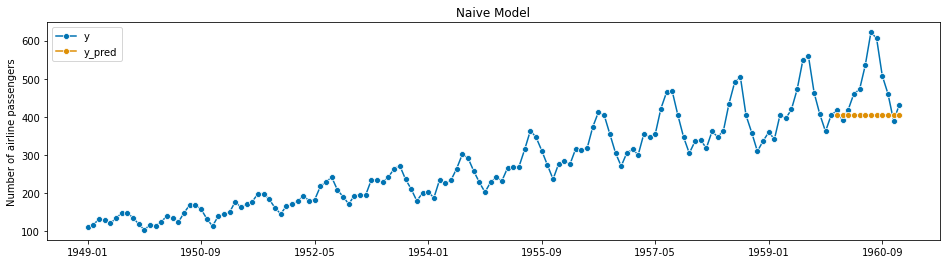

In [10]:
forecaster = NaiveForecaster(strategy='last')  # monthly seasonal periodicity
run_forecast(y_train, y_test, forecaster, fh, results=False, title="Naive Model")

Exponential Smoothing (Holt Winters)

sMAPE:  0.16155480390887256


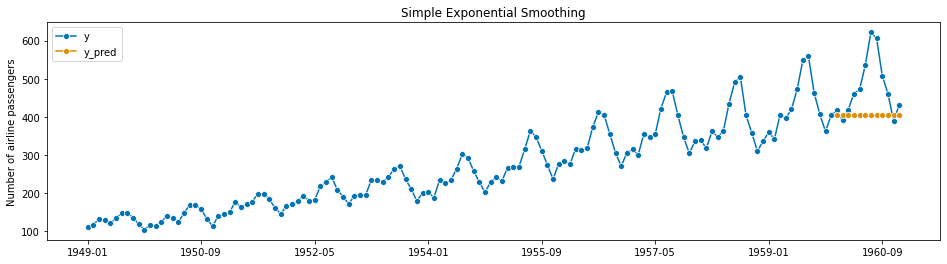

In [11]:
forecaster = ExponentialSmoothing()
run_forecast(y_train, y_test, forecaster, fh, coverage=None, results=False, 
             title="Simple Exponential Smoothing")

sMAPE:  0.14023178895227414


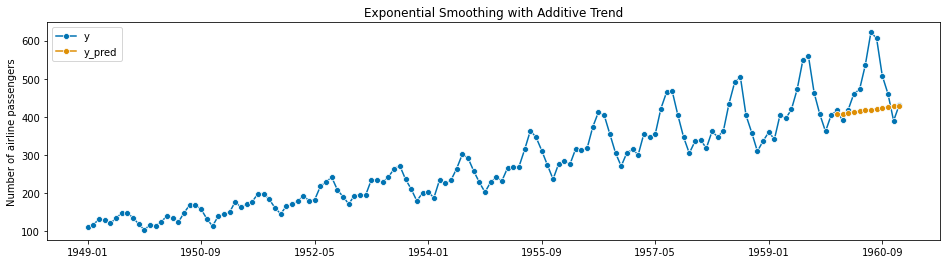

In [12]:
forecaster = ExponentialSmoothing(trend='add')
run_forecast(y_train, y_test, forecaster, fh, coverage=None, results=False, 
             title="Exponential Smoothing with Additive Trend")

sMAPE:  0.02795240869632776


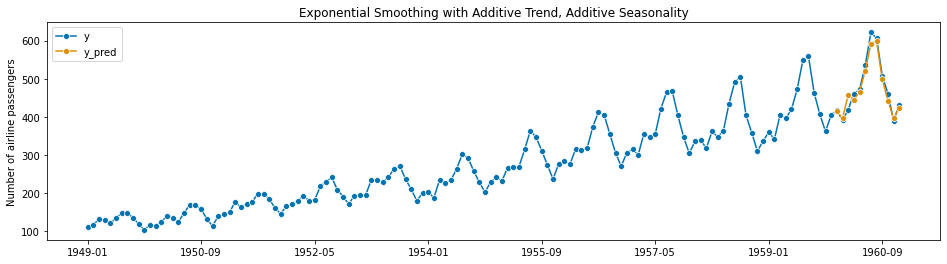

In [13]:
forecaster = ExponentialSmoothing(trend='add', seasonal='add', sp=12)
run_forecast(y_train, y_test, forecaster, fh, coverage=None, results=False,
            title="Exponential Smoothing with Additive Trend, Additive Seasonality")

AutoETS

sMAPE:  0.027163603869653663


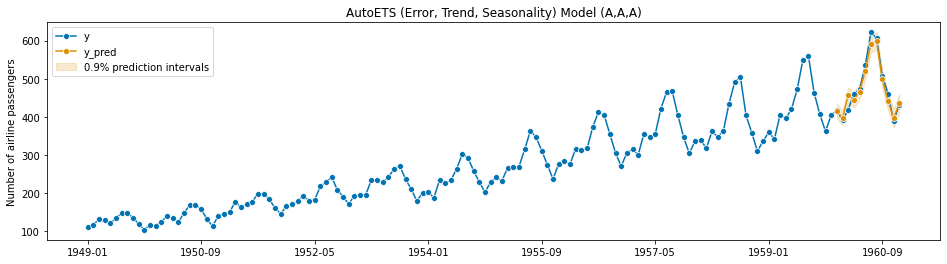

In [14]:
forecaster = AutoETS(error='add', trend='add', seasonal='add', sp=12)
run_forecast(y_train, y_test, forecaster, fh, coverage=0.9, results=False,
            title="AutoETS (Error, Trend, Seasonality) Model (A,A,A)")

StatsForecast AutoARIMA (Box-Jenkins)

sMAPE:  0.040386441846221005


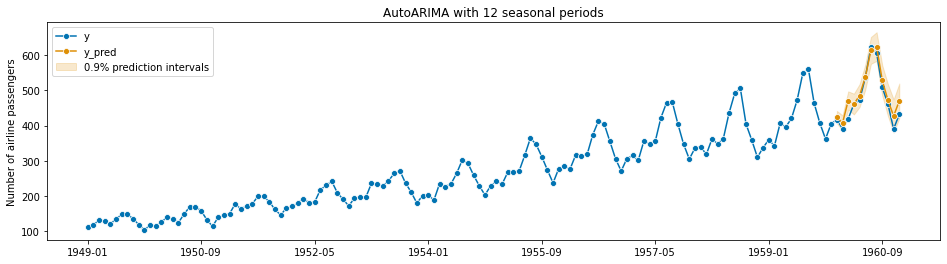

In [15]:
forecaster = StatsForecastAutoARIMA(sp=12, d=1, max_p=2, max_q=2)
run_forecast(y_train, y_test, forecaster, fh, coverage=0.9, results=False,
            title="AutoARIMA with 12 seasonal periods")

Unobserved Components

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_structural_harvey_jaeger.html

sMAPE:  0.1472775915337731


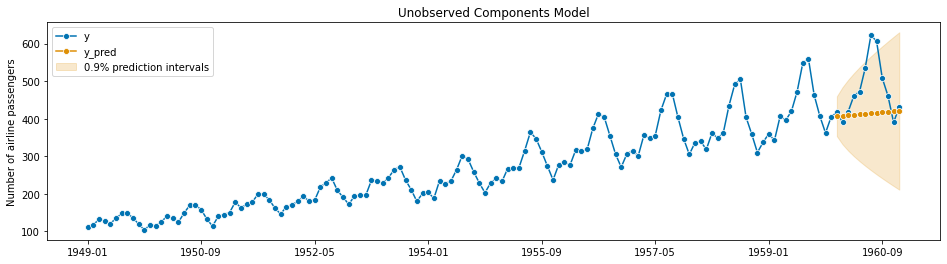

In [16]:
forecaster = UnobservedComponents(level="local linear trend", cycle=True, damped_cycle=True, stochastic_cycle=True)
forecaster, y_pred = run_forecast(y_train, y_test, forecaster, fh, coverage=0.9, results=True,
                                 title="Unobserved Components Model")

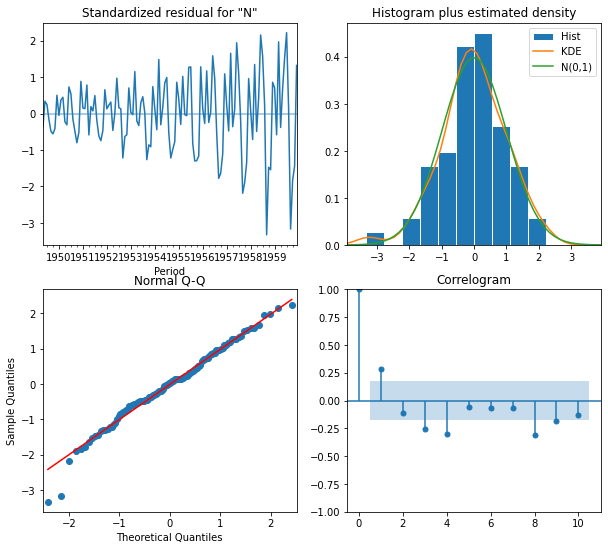

In [17]:
forecaster.plot_diagnostics(figsize=(10,9)) # Set the figsize to large for high resolution screens

In [18]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             Unobserved Components Results                              
========================================================================================
Dep. Variable:     Number of airline passengers   No. Observations:                  132
Model:                       local linear trend   Log Likelihood                -629.951
                      + damped stochastic cycle   AIC                           1271.902
Date:                          Fri, 03 Jun 2022   BIC                           1289.014
Time:                                  16:42:19   HQIC                          1278.855
Sample:                              01-31-1949                                         
                                   - 12-31-1959                                         
Covariance Type:                            opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.241e-06     97.894   1.27e-08      1.000    -191.869     191.869
sigma2.level      1013.7659   8218.264      0.123      0.902   -1.51e+04    1.71e+04
sigma2.trend      1.129e-07     30.479    3.7e-09      1.000     -59.738      59.738
sigma2.cycle      2.056e-05   8187.919   2.51e-09      1.000    -1.6e+04     1.6e+04
frequency.cycle      0.0436      0.068      0.640      0.522      -0.090       0.177
damping.cycle        1.0000      0.088     11.348      0.000       0.827       1.173
===================================================================================
Ljung-Box (L1) (Q):                  10.74   Jarque-Bera (JB):                 5.67
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               7.91   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

With unobserved components, it's helpful to be able to plot the components...which doesn't appear to be possible in `sktime`. Below we use statsmodels to plot the results: 

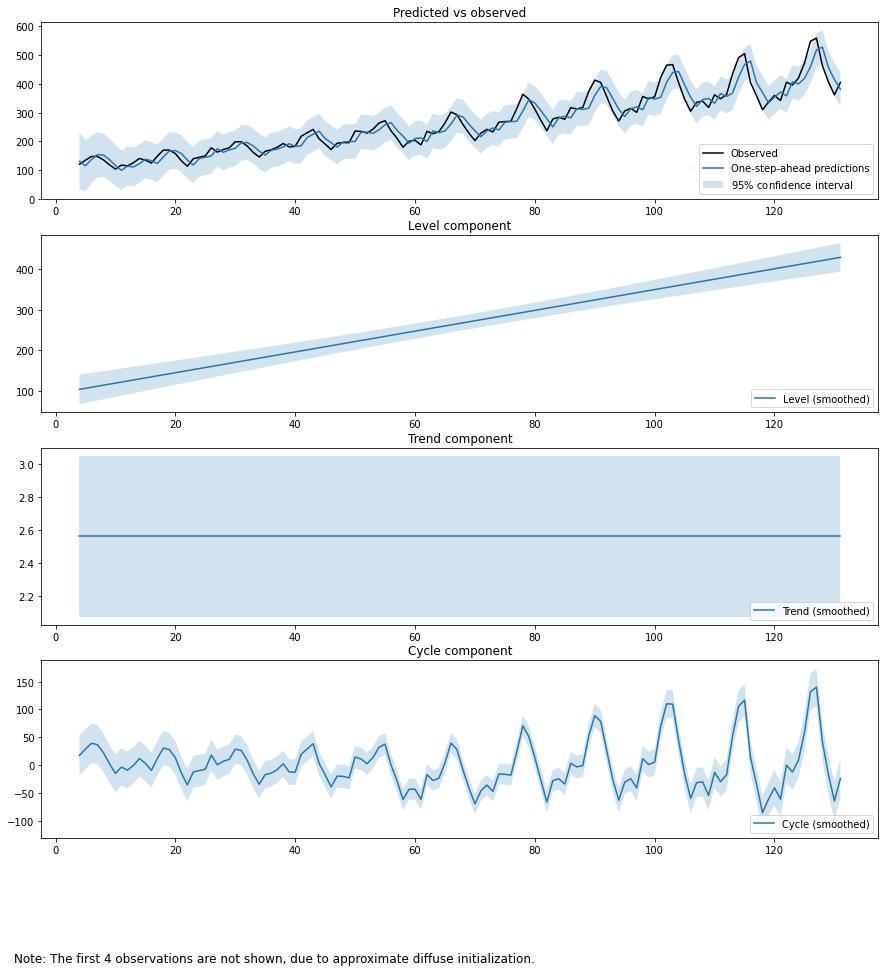

In [19]:
import statsmodels.api as sm

# Model specifications

# Unrestricted model, using string specification
unrestricted_model = {
    'level': 'local linear trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
}

y_train2 = y_train.reset_index()["Number of airline passengers"]

# Output
output_mod = sm.tsa.UnobservedComponents(y_train2, **unrestricted_model)
output_res = output_mod.fit(method='powell', disp=False)

# print(output_res.summary())
fig = output_res.plot_components(legend_loc='lower right', figsize=(15, 15));

And we can calculate the MAPE quickly:

In [20]:
np.mean(np.abs((output_res.predict(start=132, end=132+11).values - y_test.values)/y_test.values))

0.11036773716103883

### FB Prophet

2022-06-03 16:42:36 prophet INFO: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-06-03 16:42:36 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


sMAPE:  0.044003264359127055


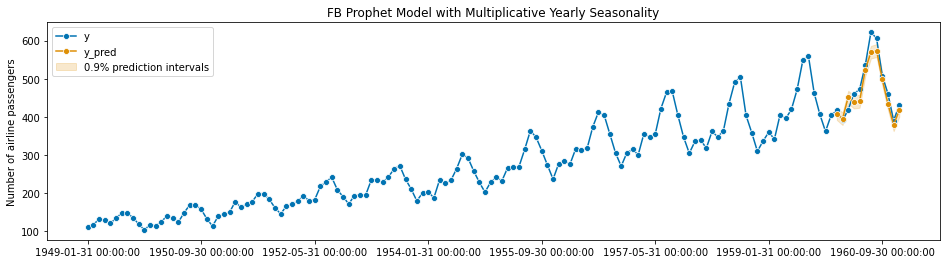

In [22]:
# Prophet requires to have data with a pandas.DatetimeIndex
y = load_airline().to_timestamp(freq='M')
y_train2, y_test2 = temporal_train_test_split(y, test_size=12)
fh2 = ForecastingHorizon(y_test2.index, is_relative=False)

forecaster = Prophet(
    seasonality_mode='multiplicative',
    n_changepoints=int(len(y) / 12),
    add_country_holidays={'country_name': 'Germany'},
    yearly_seasonality=True)
forecaster, y_pred = run_forecast(y_train2, y_test2, forecaster, fh2, coverage=0.9, results=True,
                                  title="FB Prophet Model with Multiplicative Yearly Seasonality")

In [23]:
# redo y
y = load_airline()

## Comparing Against a Heuristic Baseline

Now let's try a 'linearity' model which predicts quarterly spending based a monthly "percentage of full quarter spending" approach. This is a common approach when predicting how the end of quarter spending is shaping up.

In [24]:
# "Linearity" based on date
y_t = pd.DataFrame(y)
y_t["Q"] = y_t.index.quarter
y_t["YYYYQ"] = y_t.index.year.astype(str) + y_t.index.quarter.astype(str)

# Cumulative Percentage of the Quarter
y_t["cum_pct"] = y_t.groupby(by="YYYYQ")["Number of airline passengers"].transform(lambda x: np.cumsum(x)/sum(x))
y_t["cum_sum"] = y_t.groupby(by="YYYYQ")["Number of airline passengers"].transform(lambda x: np.cumsum(x))
y_t["qtr_total"] = y_t.groupby(by="YYYYQ")["Number of airline passengers"].transform(lambda x: sum(x))

In [25]:
# Find the month, and month in quarter using a mapping dictionary
month_in_qtr = dict()
for j in np.arange(1,4):
    for i in range(j,13,3):
        month_in_qtr[i] = j
y_t["M"] = y_t.index.month
y_t["Month_in_Qtr"] = y_t["M"].map(month_in_qtr)

In [26]:
# Calculate the Previous 4Q Average Percent of Qtr Spending
y_t["P4Q_avg"] = y_t.groupby("Month_in_Qtr")['cum_pct'].transform(lambda x: x.rolling(4).mean())

<AxesSubplot:xlabel='Period'>

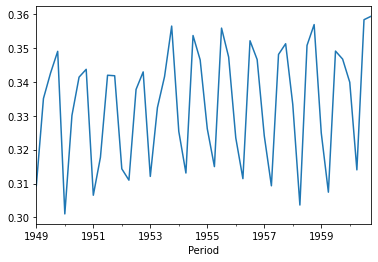

In [27]:
y_t.query("Month_in_Qtr==1")["cum_pct"].plot()

In [28]:
# Make the Prediction 
y_t["Pred1"] = y_t["cum_sum"]/y_t["P4Q_avg"]

MAPE:  0.04624210089028735
sMAPE:  0.04644477882368189


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='qtr_total'>)

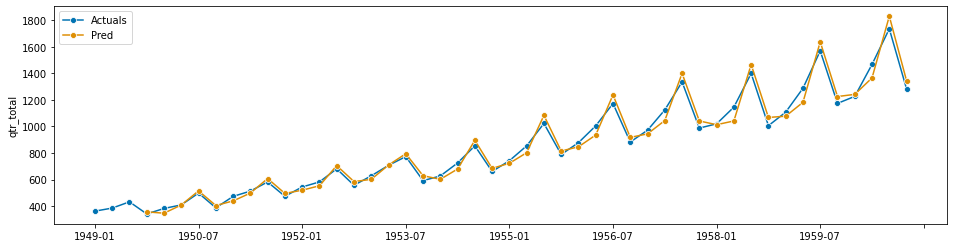

In [29]:
# Calculate accuracy scores and plot the forecasts
subset = y_t.query("Month_in_Qtr==1")
print("MAPE: ", mean_absolute_percentage_error(subset.qtr_total[4:], subset.Pred1[4:], symmetric=False))
print("sMAPE: ", mean_absolute_percentage_error(subset.qtr_total[4:], subset.Pred1[4:], symmetric=True))
# Quarterly Data
plot_series(subset.qtr_total, subset.Pred1, labels=["Actuals", "Pred"])

MAPE:  0.03226663000165359
sMAPE:  0.032058941340971044


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='qtr_total'>)

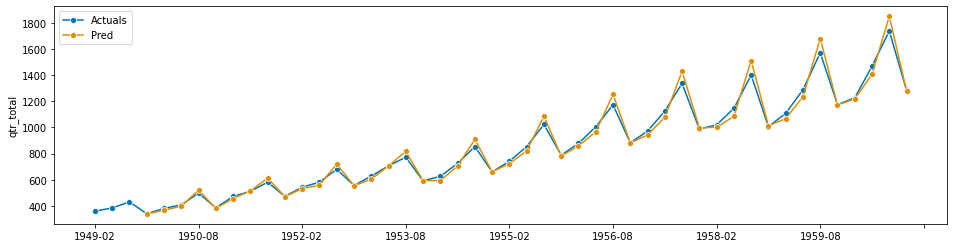

In [30]:
subset = y_t.query("Month_in_Qtr==2")
print("MAPE: ", mean_absolute_percentage_error(subset.qtr_total[4:], subset.Pred1[4:], symmetric=False))
print("sMAPE: ", mean_absolute_percentage_error(subset.qtr_total[4:], subset.Pred1[4:], symmetric=True))
# Quarterly Data
plot_series(subset.qtr_total, subset.Pred1, labels=["Actuals", "Pred"])

Great accuracy scores on the airpassengers dataset, but this is only forecasting for the end of each quarter, it can't forecast beyond that horizon. 